Observations and experimentation for NON-XML:

* kernel_size of (3,3) and (5,5) gives higher accuracies, tried (7,7) and (9,9) but accuracy was poorer (~50-70%)
* image augmentation: imageDataGen gives similar accuracies to regular resizing model (~80-90%), but imageDataGen helps to provide more training images.

observations for imgDataGen:
* increasing batch-size from 1 to 20 greatly improves accuracy. see graphs for difference, 1 has hugely oscillating accuracies.
* batch size of 25, better. unable to increase higher batch size because insufficient data
* change epochs from 100 to 200, better result
* adding extra dense layer with 256 units worsens accuracy too.

for vgg16 model:
* learning rate of 0.000001 performs well with 0.8166 accuracy, higher learning rates give poorer accuracies.
* However, training is significantly longer than imgDataGen with basic model (implementation 2). Accuracy of VGG16 is lower too.
* Therefore, the basic model which is simpler and has a higher accuracy may be more favourable.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
import os
from bs4 import BeautifulSoup

a. Image processing
==
1. Resizing method

In [53]:
from os.path import isfile
import glob

curr_dir = os.getcwd()
train_path = curr_dir + "/train/"
test_path = curr_dir + "/test/"
class_names = ["apple", "banana", "mixed", "orange"]

files_train = [img for img in glob.glob(train_path + "*.jpg")]
files_test = [img for img in glob.glob(test_path + "*.jpg")]
files_train_xml = [img for img in glob.glob(train_path + "*.xml", recursive = True)]
files_test_xml = [img for img in glob.glob(test_path + "*.xml", recursive = True)]

In [54]:
def PreProcessXML(files):

    data_crop_xml = []
    for file in files:
        with open(file) as f:
            data = f.read()

        Bs_data = BeautifulSoup(data, 'html.parser')

        x_min = min([int(item.get_text()) for item in Bs_data.find_all('xmin')])
        x_max = max([int(item.get_text()) for item in Bs_data.find_all('xmax')])
        y_min = min([int(item.get_text()) for item in Bs_data.find_all('ymin')])
        y_max = max([int(item.get_text()) for item in Bs_data.find_all('ymax')])

        x_y_data = [x_min,y_max,x_max,y_min]
        data_crop_xml.append(x_y_data)

    return data_crop_xml

data_train_crop_xml = PreProcessXML(files_train_xml)
data_test_crop_xml = PreProcessXML(files_test_xml)
print(data_train_crop_xml)

[[15, 291, 255, 87], [5, 276, 287, 31], [234, 343, 416, 132], [1, 250, 224, 1], [121, 354, 514, 93], [23, 265, 272, 33], [96, 397, 580, 107], [26, 295, 300, 28], [76, 439, 759, 58], [254, 720, 617, 231], [24, 398, 600, 1], [99, 416, 670, 8], [87, 415, 603, 127], [57, 459, 615, 239], [125, 374, 363, 144], [133, 595, 725, 115], [97, 326, 366, 62], [36, 282, 271, 38], [3, 263, 342, 61], [4, 434, 409, 92], [140, 688, 965, 61], [4, 398, 366, 71], [117, 175, 489, 81], [17, 201, 421, 57], [79, 282, 596, 32], [19, 708, 719, 1], [291, 342, 588, 55], [6, 206, 206, 18], [56, 332, 413, 98], [67, 155, 222, 8], [125, 497, 772, 133], [159, 336, 520, 45], [4, 926, 1818, 3], [10, 4515, 2466, 625], [24, 235, 253, 11], [86, 290, 422, 12], [184, 525, 582, 110], [92, 522, 546, 66], [26, 239, 222, 56], [46, 514, 770, 59], [31, 222, 157, 82], [344, 394, 640, 76], [1, 810, 651, 132], [71, 220, 258, 18], [97, 320, 533, 83], [1, 676, 532, 171], [130, 1800, 1071, 621], [193, 983, 1700, 207], [75, 328, 563, 21], 

In [60]:
x_resize = 64
y_resize = 64

(Not using XML, some preprocessing)

In [61]:
def process_image(files, path, method):
    x = None
    y = []
    for i in range(len(files)):
        img = Image.open(files[i])
        img_resize = img.resize((x_resize, y_resize))
        if img_resize.mode in ["RGBA", "P"]:
            img_resize = img_resize.convert("RGB")
        if x is None:
            x = img_resize
        else:
            x = np.concatenate((x, img_resize))
        y.append(os.path.basename(files[i]).split('_')[0])
        img_name = os.path.basename(files[i]).split('.')[0]
        save_path = path + "resize/" + img_name
        # save_image(img_resize, method, save_path)

    x = x.reshape(-1, x_resize, y_resize, 3)
    le = LabelEncoder()
    y = le.fit_transform(y)

    return x,y

def save_image(img, method, save_path):
    if method == 'resize':
        img.save(save_path + "_{}x{}.jpg".format(x_resize, y_resize))

In [84]:
x_train, y_train = process_image(files_train, train_path, 'resize')
x_test, y_test = process_image(files_test, test_path, 'resize')

In [64]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(240, 64, 64, 3)
(60, 64, 64, 3)
(240,)
(60,)


Preview images before training.

In [65]:
# preview of images
def plot_summary_view(is_train):
    if is_train:
        x = x_train
        y = y_train
    else:
        x = x_test
        y = y_test

    plt.figure(figsize=(20,20))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.grid(False)
        plt.imshow(x[i])
        plt.title(class_names[y[i]])
        # plt.title(class_names[np.argmax(y[i])])
    plt.show()

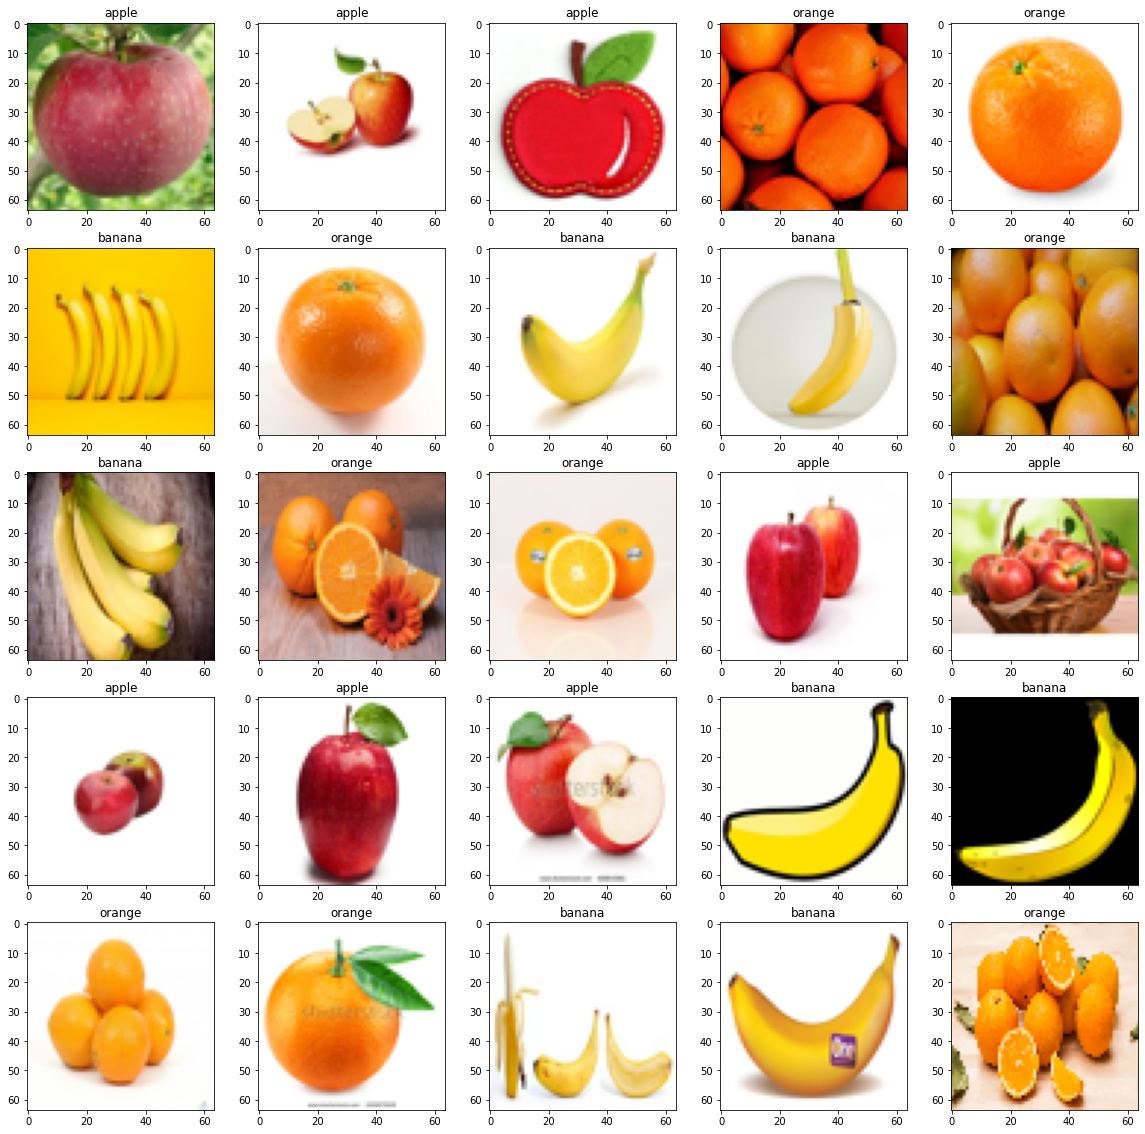

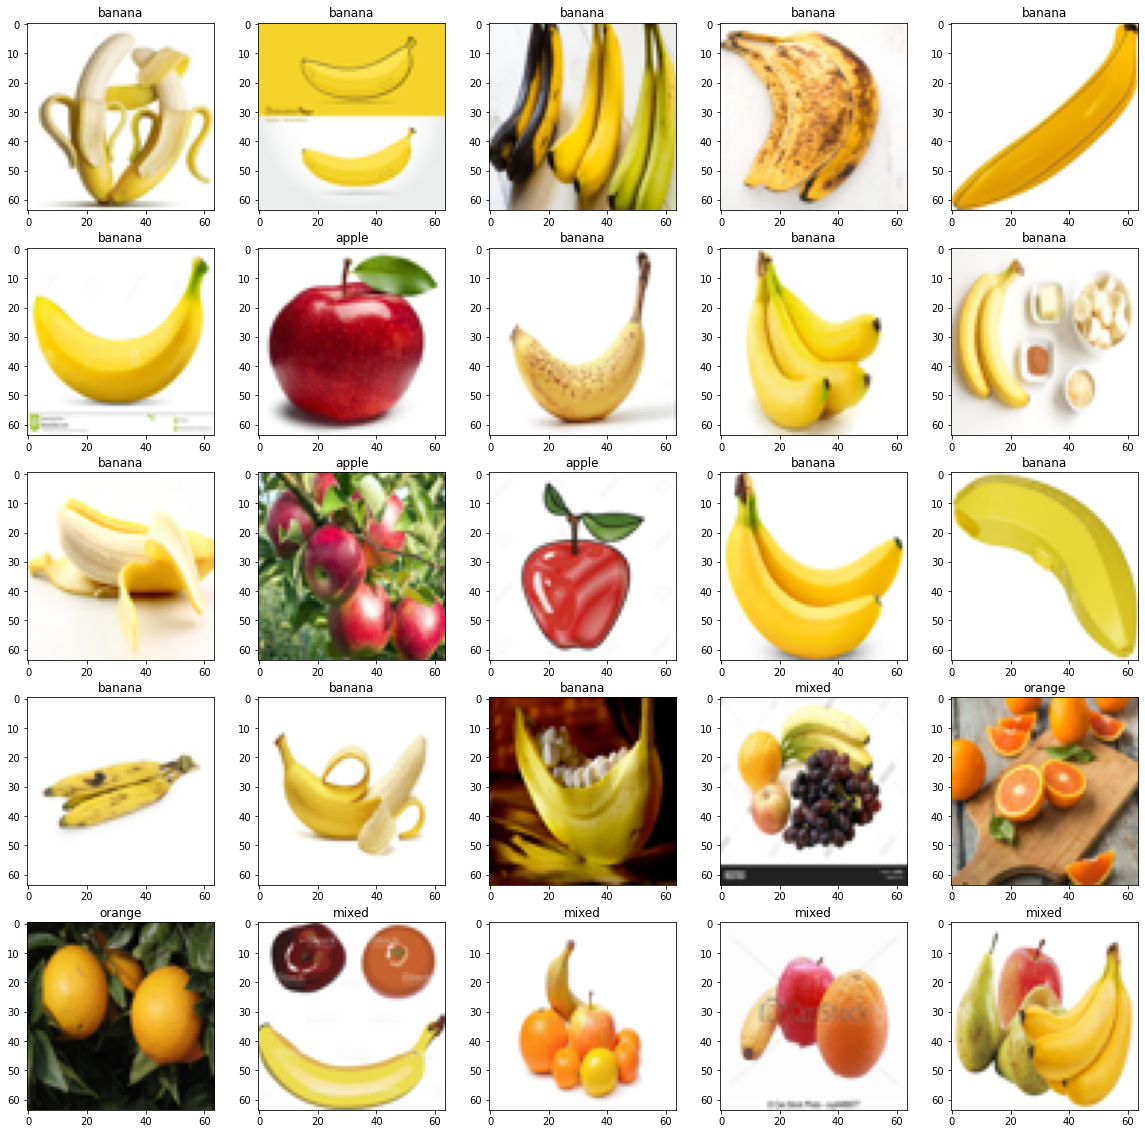

In [66]:
plot_summary_view(True)
plot_summary_view(False)

### Implementation 1
Simple model like Cherwah's, using ImageDataGenerator.
Batch size 1, epoch = 100

In [92]:
from keras_preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGen = ImageDataGenerator(rescale = 1./255)

# takes some time to load btw.
train_generator = trainGen.flow(x=x_train, y=y_train, batch_size=1, shuffle=True)
test_generator = testGen.flow(x=x_test, y=y_test, batch_size=1, shuffle=True)

In [93]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 activation='relu',
                                 input_shape=(x_resize, y_resize, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [94]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [95]:
with tf.device('/device:GPU:0'):
    hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100)

Epoch 1/100


2021-11-27 15:28:19.059364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 21ms/step - loss: 2.1402 - accuracy: 0.1000 - val_loss: 1.4270 - val_accuracy: 0.1000
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 1.4075 - accuracy: 0.1000    

2021-11-27 15:28:19.572091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 17ms/step - loss: 1.4075 - accuracy: 0.1000 - val_loss: 1.3422 - val_accuracy: 0.2000
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 1.3903 - accuracy: 0.2000 - val_loss: 1.3575 - val_accuracy: 0.1000
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4174 - accuracy: 0.1000 - val_loss: 1.3811 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3772 - accuracy: 0.2000 - val_loss: 1.3873 - val_accuracy: 0.2000
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3

In [96]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 23ms/step - loss: 1.5116 - accuracy: 0.3167
1.51164710521698
0.31666669249534607


2021-11-27 15:28:35.384570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


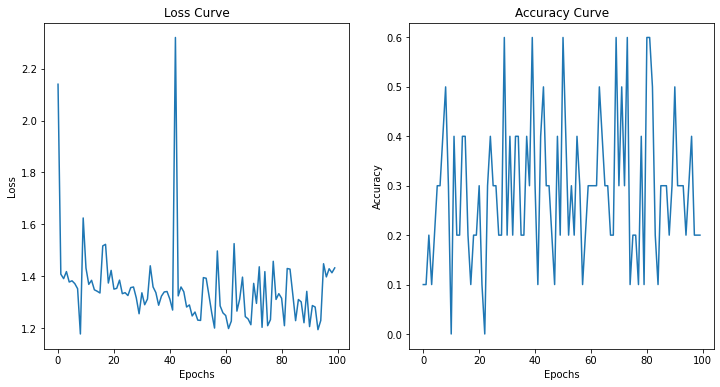

In [97]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

#### Summary
    In this implementation, train and test accuracy are poor, with oscillating accuracies.
    Action to refine the model:
        (1) increase batch size in train and test generator.

### Implementation 2
Same as implementation 1, but batch size = 20.

In [98]:
from keras_preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGen = ImageDataGenerator(rescale = 1./255)

# takes some time to load btw.
train_generator = trainGen.flow(x=x_train, y=y_train, batch_size=20, shuffle=True)
test_generator = testGen.flow(x=x_test, y=y_test, batch_size=20, shuffle=True)

In [99]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 activation='relu',
                                 input_shape=(x_resize, y_resize, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [100]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [101]:
with tf.device('/device:GPU:0'):
    hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100)

Epoch 1/100
 1/10 [==>...........................] - ETA: 2s - loss: 1.3883 - accuracy: 0.2000

2021-11-27 15:28:56.677411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 33ms/step - loss: 1.3387 - accuracy: 0.4200 - val_loss: 0.9330 - val_accuracy: 0.6000
Epoch 2/100
 4/10 [===========>..................] - ETA: 0s - loss: 0.9991 - accuracy: 0.5625

2021-11-27 15:28:57.030902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 19ms/step - loss: 0.8784 - accuracy: 0.6550
Epoch 3/100
10/10 [==============================] - 0s 19ms/step - loss: 0.8461 - accuracy: 0.7150
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 0.7075 - accuracy: 0.7950

In [102]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 24ms/step - loss: 378.7567 - accuracy: 0.7000
378.75665283203125
0.7000000476837158


2021-11-27 15:29:18.340080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


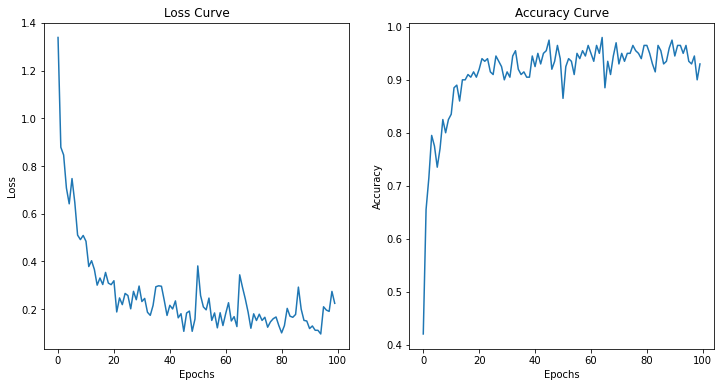

In [103]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

#### Summary
    In this implementation, train accuracy > 90%, test accuracy significantly improved from Implementation 1.
    Action to refine the model:
        (1) Increase kernel size.


### Implementation 2b
Same as implementation 1, but batch size = 25.

In [203]:
from keras_preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGen = ImageDataGenerator(rescale = 1./255)

# takes some time to load btw.
train_generator = trainGen.flow(x=x_train, y=y_train, batch_size=25, shuffle=True)
test_generator = testGen.flow(x=x_test, y=y_test, batch_size=25, shuffle=True)

In [173]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 activation='relu',
                                 input_shape=(x_resize, y_resize, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [174]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [175]:
with tf.device('/device:GPU:0'):
    hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100)

Epoch 1/100
 1/10 [==>...........................] - ETA: 2s - loss: 1.4392 - accuracy: 0.2400

2021-11-27 15:54:41.655834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 45ms/step - loss: 1.4158 - accuracy: 0.3583 - val_loss: 1.1237 - val_accuracy: 0.4500
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.1205 - accuracy: 0.5200

2021-11-27 15:54:42.078679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 21ms/step - loss: 1.0140 - accuracy: 0.5833
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 0.7768 - accuracy: 0.7500
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - loss: 0.6751 - accuracy: 0.7750

In [176]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 78ms/step - loss: 180.8995 - accuracy: 0.8833


2021-11-27 15:55:09.614941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


180.89947509765625
0.8833333849906921


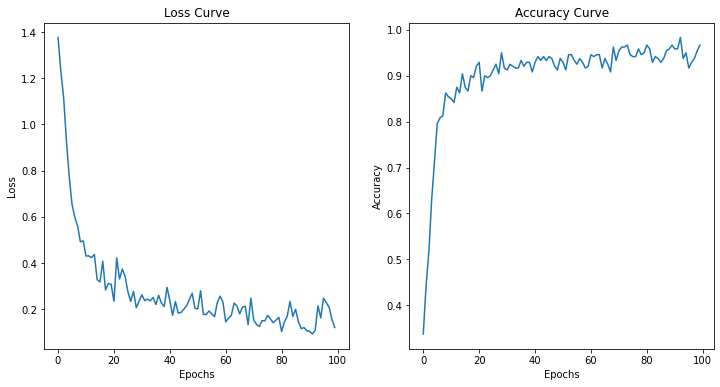

In [168]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

#### Summary
    In this implementation, accuracy increased further.
    Action to refine the model:
        (1) Increase kernel size.

### Implementation 3
Batch size = 25, kernel size (3,3) and (7,7).

In [134]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 activation='relu',
                                 input_shape=(x_resize, y_resize, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(7,7),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [135]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [136]:
with tf.device('/device:GPU:0'):
    hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100)

Epoch 1/100
 1/10 [==>...........................] - ETA: 2s - loss: 1.4542 - accuracy: 0.2800

2021-11-27 15:44:29.727858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 58ms/step - loss: 1.3437 - accuracy: 0.4167 - val_loss: 1.0068 - val_accuracy: 0.6667
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.9173 - accuracy: 0.7200

2021-11-27 15:44:30.329323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 28ms/step - loss: 0.9879 - accuracy: 0.5958
Epoch 3/100
10/10 [==============================] - 0s 30ms/step - loss: 0.8343 - accuracy: 0.6083
Epoch 4/100
10/10 [==============================] - 0s 29ms/step - loss: 0.6990 - a

In [137]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 45ms/step - loss: 237.5517 - accuracy: 0.8167
237.5517120361328
0.8166667222976685


2021-11-27 15:45:01.847844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


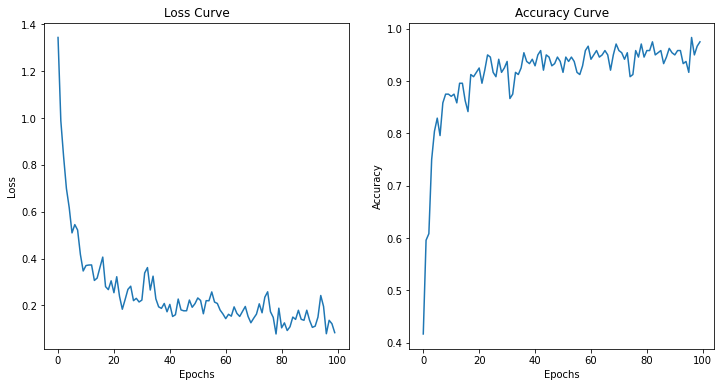

In [138]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

#### Summary
    In this implementation, test accuracy decreased by 0.02
    Action to refine the model:
        (1) Keep to old kernel size, try out with new Dense layer

### Implementation 4
Batch size = 25, kernel size (3,3) and (5,5), new Dense layer, 256 units


In [155]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 activation='relu',
                                 input_shape=(x_resize, y_resize, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [156]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [157]:
with tf.device('/device:GPU:0'):
    hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100)

Epoch 1/100
 1/10 [==>...........................] - ETA: 2s - loss: 1.4575 - accuracy: 0.2400

2021-11-27 15:51:56.959169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 46ms/step - loss: 1.3431 - accuracy: 0.3708 - val_loss: 1.1243 - val_accuracy: 0.5333
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.0557 - accuracy: 0.5600

2021-11-27 15:51:57.441373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 23ms/step - loss: 1.1087 - accuracy: 0.5250
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 0.9934 - accuracy: 0.5875
Epoch 4/100
10/10 [==============================] - 0s 31ms/step - loss: 0.7416 - accuracy: 0.7292

In [158]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 38ms/step - loss: 485.5898 - accuracy: 0.6667
485.5897521972656
0.6666666865348816


2021-11-27 15:52:23.746568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


#### Summary
    In this implementation, test accuracy quite similar to implementation 2 (does not have dense layer)
    Action to refine the model:
        (1) Take out extra dense layer to simplify model
        (2) Try out with higher epochs

### Implementation 5
Batch size = 20, kernel size (3,3) and (5,5), epochs = 200


In [143]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 activation='relu',
                                 input_shape=(x_resize, y_resize, 3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [144]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [145]:
with tf.device('/device:GPU:0'):
    hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=200)

Epoch 1/200
 1/10 [==>...........................] - ETA: 2s - loss: 1.4533 - accuracy: 0.2000

2021-11-27 15:47:52.772062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 47ms/step - loss: 1.4895 - accuracy: 0.3333 - val_loss: 1.1546 - val_accuracy: 0.3167
Epoch 2/200
 1/10 [==>...........................] - ETA: 0s - loss: 1.1832 - accuracy: 0.2800

2021-11-27 15:47:53.231011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 23ms/step - loss: 1.0861 - accuracy: 0.4667
Epoch 3/200
10/10 [==============================] - 0s 24ms/step - loss: 0.8291 - accuracy: 0.7458
Epoch 4/200
10/10 [==============================] - 0s 22ms/step - loss: 0.7899 - accuracy: 0.7208

In [147]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 17ms/step - loss: 447.6812 - accuracy: 0.7333
447.6812438964844
0.7333333492279053


#### Summary
    In this implementation, test accuracy decreased
    Action to refine the model:
        (1) Keep to epochs = 100.

### Next steps: Plot images with labels to show accuracy of predictions
Using implementation 2b (batch size 25, kernel (3,3), (5,5), epochs 100)

1. Define function to plot image
2. Define function to plot bar chart to show relative probabilities


In [148]:
def plot_image(i, pred, true_label, test_img):
    plt.grid(False)
    plt.imshow(test_img[i])

    pred_label = np.argmax(pred[i])

    if pred_label == true_label[i]:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("predicted: {} {:2.0f}% (actual: {})".format(class_names[pred_label],
                                                           100*np.max(pred[i]),
                                                           class_names[true_label[i]]),
                                                           color=color)

In [149]:
def plot_probs(i, pred, true_label):
    plt.xticks(range(4), class_names, rotation=45)
    # cannot take argmax, must take other indices also. EXCEPT the pred.
    # np.delete abit inefficient time wise
    pred_arr = np.arange(0,4,1)
    pred_arr = np.delete(pred_arr, true_label[i])
    plot = plt.bar(range(4),pred[i])
    plt.ylim([0,1])

    for label in pred_arr:
        plot[label].set_color('red')
    plot[true_label[i]].set_color('green')

3. Plot test images with labels and probabilities of prediction

In [178]:
predictions = model.predict(x_test)

2021-11-27 15:56:52.927666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [179]:
num_rows = 10
num_cols = 6
num_images = num_rows * num_cols

In [161]:
def plot_result():
# 2x figure size
    plt.figure(figsize=(2*num_rows, 2*2*num_cols))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions, y_test, x_test)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_probs(i, predictions, y_test)
    plt.tight_layout()
    plt.show()

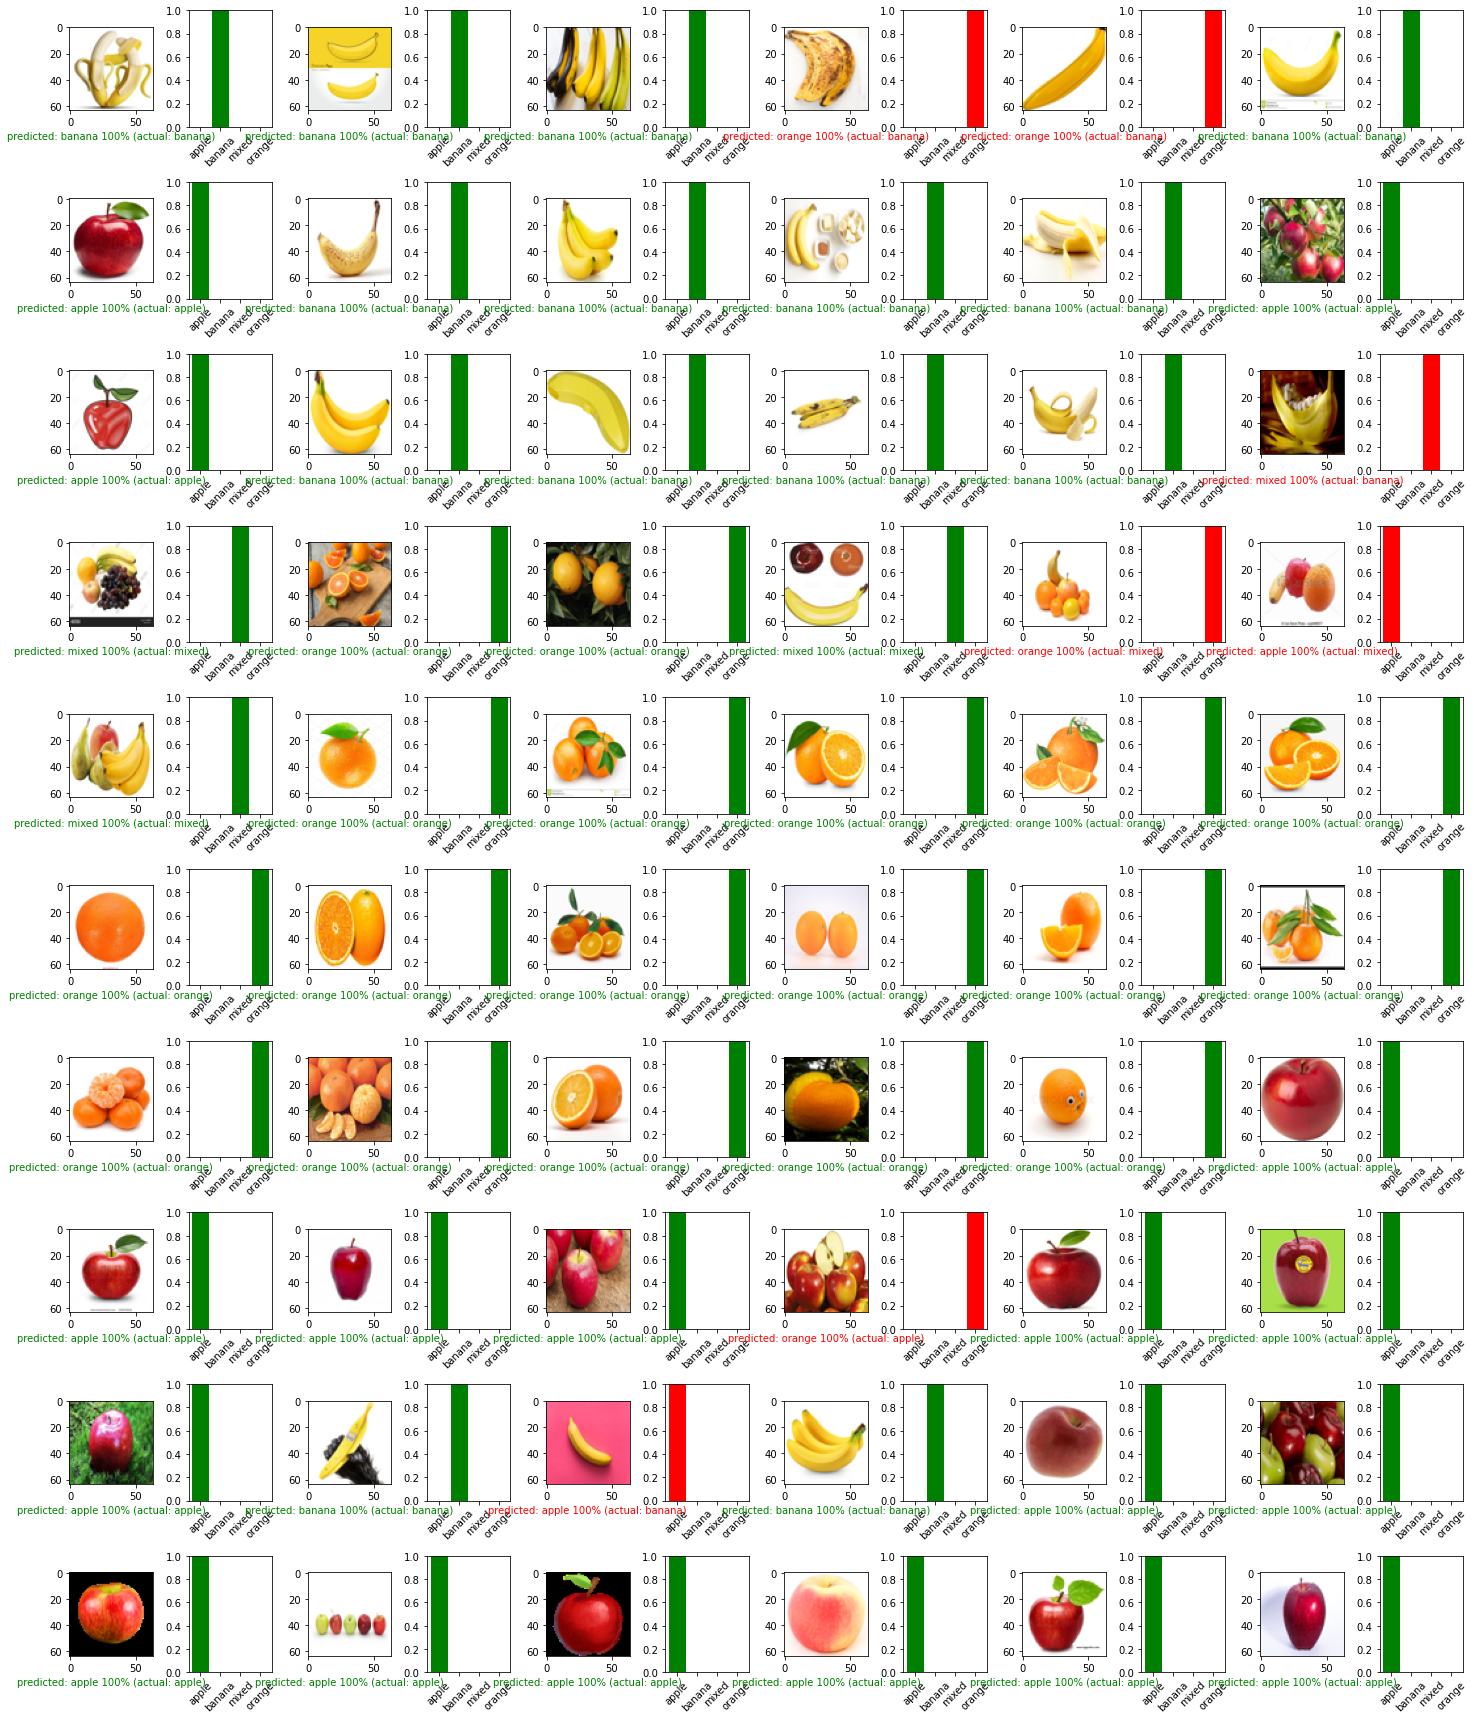

In [180]:
plot_result()

#### Insights
    (1) Interestingly, some of mixed was predicted correctly.
    (2) Some were misidentified due to background color/fruit colors in image:
        - banana with red background identified as apple.
        - banana with orange tint identified as orange.
    Therefore, there may be a need to crop the images to reduce noise from background.

### Implementation 6: building vgg model from scratch

Credits: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

* Also includes early stopping here

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGen = ImageDataGenerator(rescale = 1./255)

# takes some time to load btw.
train_generator = trainGen.flow(x=x_train, y=y_train, batch_size=25, shuffle=True)
test_generator = testGen.flow(x=x_test, y=y_test, batch_size=25, shuffle=True)

In [195]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.models import Sequential

# manual vgg16 model
model = Sequential()
model.add(Conv2D(input_shape=(x_resize, y_resize,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=len(class_names), activation="softmax"))

In [190]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [192]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100,
                           callbacks=[checkpoint,early])


Epoch 1/100


/Users/xinyitay/miniforge3/envs/gdip/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


10/10 [==============================] - 2s 214ms/step - loss: 1.2975 - accuracy: 0.2875

Epoch 00001: accuracy improved from -inf to 0.28750, saving model to vgg16_1.h5
Epoch 2/100
10/1

In [193]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2021-11-27 16:05:01.459484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 86ms/step - loss: 1.3361 - accuracy: 0.3167
1.3360527753829956
0.31666669249534607


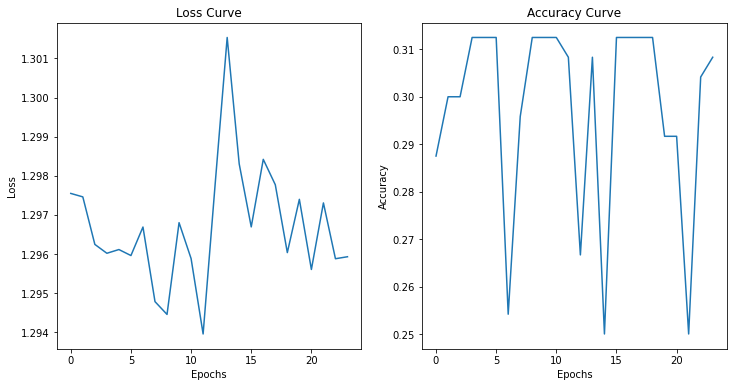

In [194]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

#### Summary
    In this implementation, test accuracy is poor (~30%). Oscillating losses observed again.
    Action to refine the model:
        (1) Decrease learning rate from 0.001 to 0.00001


### Implementation 6b
Learning rate 0.00001

In [210]:
from keras_preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGen = ImageDataGenerator(rescale = 1./255)

# takes some time to load btw.
train_generator = trainGen.flow(x=x_train, y=y_train, batch_size=25, shuffle=True)
test_generator = testGen.flow(x=x_test, y=y_test, batch_size=25, shuffle=True)

In [211]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.models import Sequential

# manual vgg16 model
model = Sequential()
model.add(Conv2D(input_shape=(x_resize, y_resize,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=len(class_names), activation="softmax"))

In [212]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [213]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100,
                           callbacks=[checkpoint,early])

Epoch 1/100


2021-11-27 16:15:36.680947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 1.3851 - accuracy: 0.2542 

2021-11-27 16:15:39.577743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 4s 268ms/step - loss: 1.3851 - accuracy: 0.2542 - val_loss: 1.3829 - val_accuracy: 0.3167

Epoch 00001: accuracy improved from -inf to 0.25417, saving model to vgg16_1.h5
Epoch 2/100
10/10 [==============================] - 2s 212ms/step - loss: 1.3792 - accuracy: 0.2875

In [214]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2021-11-27 16:20:05.921206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 185ms/step - loss: 191.6322 - accuracy: 0.7667
191.63217163085938
0.7666667103767395


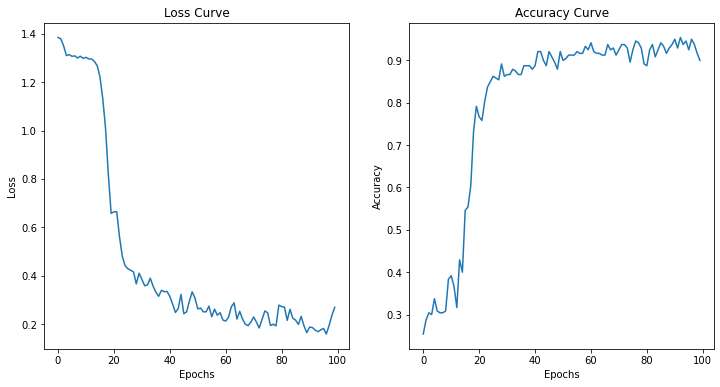

In [215]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

#### Summary
    Decreasing learning rate significantly increases the accuracy.
    Action to refine the model:
        (1) Further decrease learning rate from 0.00001 to 0.000001

### Implementation 6c
Learning rate 0.000001

In [216]:
from keras_preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGen = ImageDataGenerator(rescale = 1./255)

# takes some time to load btw.
train_generator = trainGen.flow(x=x_train, y=y_train, batch_size=25, shuffle=True)
test_generator = testGen.flow(x=x_test, y=y_test, batch_size=25, shuffle=True)

In [217]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.models import Sequential

# manual vgg16 model
model = Sequential()
model.add(Conv2D(input_shape=(x_resize, y_resize,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=len(class_names), activation="softmax"))

In [218]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.000001)
model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [224]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           steps_per_epoch=10,
                           validation_steps=10,
                           epochs=100,
                           callbacks=[checkpoint,early])

Epoch 1/100
10/10 [==============================] - 3s 233ms/step - loss: 1.3046 - accuracy: 0.3042 - val_loss: 1.3025 - val_accuracy: 0.3000

Epoch 00001: accuracy improved from -inf to 0.30417, saving model to vgg16_1.h5
Epoch 2/100
10/10 [==============================] - 2s 203ms/step - loss: 1.3044 - accuracy: 0.3042

In [227]:
loss, accuracy = model.evaluate(x_test,y_test)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 99ms/step - loss: 79.0087 - accuracy: 0.8167
79.00869750976562
0.8166667222976685


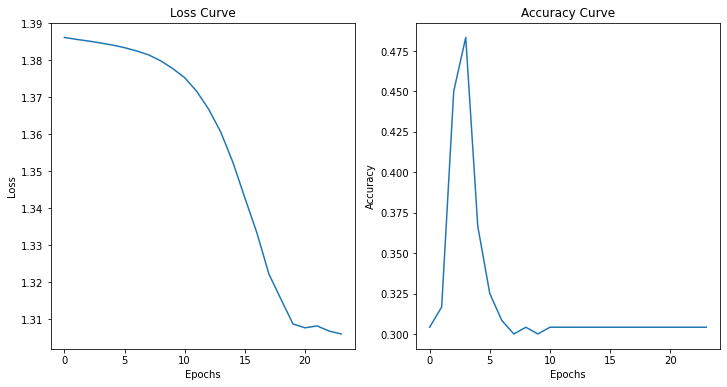

In [221]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

#### Summary
    Learning rate of 0.000001 performed better than 0.00001.
    Learing rate 0.00001 = 0.7667
    Learning rate 0.000001 = 0.81667

(archived)
Using vgg16 inbuilt model

In [222]:
# files_train = [img for img in glob.glob(train_path + "apple_1.jpg")]
# x_train, y_train = process_image(files_train, train_path, 'resize')
# # need to convert to array, only shows immage lol
# x_train

In [223]:
# from keras.applications.vgg16 import decode_predictions
#
# x_train = tf.keras.applications.vgg16.preprocess_input(
#     x_train, data_format=None
# )
# model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(x_resize, y_resize, 3),
#     pooling=None,
#     classes=len(class_names),
#     classifier_activation="softmax",
# )
# x_train_vgg = np.expand_dims(x_train, axis=0)
# features = model.predict(x_train_vgg)
# p = decode_predictions(features)
# p
